<a href="https://colab.research.google.com/github/sarthakkaushik/Cdiscount-Image-Classification/blob/main/Cdiscount_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Data from Google Drive

In [1]:
# Code to mount google drive in case you are loading the data from your google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
data_path = '/gdrive/MyDrive/UOH Assignment Dataset/cdiscount'

In [3]:
import os 
os.chdir(data_path)
print(os.getcwd())

/gdrive/MyDrive/UOH Assignment Dataset/cdiscount


Importing libraries

In [4]:
# !pip install Pillow


import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
from imageio import imread
from tqdm import tqdm_notebook
import io

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../cdiscount"]).decode("utf8"))
# Any results you write to the current directory are saved as output.
from PIL import Image




categories.csv
category_names.csv
file.h5
sample_submission.csv
test.bson
train.bson
train_example.bson
train_images.csv
train_offsets.csv
val_images.csv



#Exploring the category_names.csv table

In [5]:
data_dir = "../cdiscount/"

train_bson_path = os.path.join(data_dir, "category_names.csv")

In [6]:
# categories_df = pd.read_csv(train_bson_path, index_col='category_id')
categories_df = pd.read_csv(train_bson_path)

In [7]:
categories_df.head()

,category_id,category_level1,category_level2,category_level3
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


In [8]:
"""
Let's inspect categories and their relationship to images. We have

5270 unique categories
49 unique level 1 categories
483 unique level 2 categories
5263 unique level 3 categories

"""

print("Unique categories: ", len(categories_df['category_id'].unique()))
print("Unique level 1 categories: ", len(categories_df['category_level1'].unique()))
print("Unique level 2 categories: ", len(categories_df['category_level2'].unique()))
print("Unique level 3 categories: ", len(categories_df['category_level3'].unique()))

Unique categories:  5270
Unique level 1 categories:  49
Unique level 2 categories:  483
Unique level 3 categories:  5263


Observation 1 :- category level3 has near about same uniuqe value as category id

In [9]:
#let's dig deep and see do we observe any observation between category id and category 3

gb_obj = categories_df.groupby('category_level3')
gb_cnt = gb_obj.count()
# print(cnt)
print('No of rows with one-one mapping between category_id and Category 3 - ',len(gb_cnt[gb_cnt['category_id'] ==1]))
print('No of rows with more than one category_id for a given Category 3 - ',len(gb_cnt[gb_cnt['category_id'] >1]))
print(gb_cnt[gb_cnt['category_id'] >1])

No of rows with one-one mapping between category_id and Category 3 -  5256
No of rows with more than one category_id for a given Category 3 -  7
                                    category_id  ...  category_level2
category_level3                                  ...                 
CONFORT URINAIRE                              2  ...                2
FONTAINE A EAU                                2  ...                2
FUSIBLE                                       2  ...                2
GUIDON                                        2  ...                2
PELUCHE                                       2  ...                2
PROTEGE ECRAN - FILM DE PROTECTION            2  ...                2
VOITURE                                       2  ...                2

[7 rows x 3 columns]


In [10]:
#lets see one example of Category level 3 with more than 1 category_id
gb_obj.get_group(gb_cnt[gb_cnt['category_id'] > 1].index.values[2])


,category_id,category_level1,category_level2,category_level3
1149,1000006131,BRICOLAGE - OUTILLAGE - QUINCAILLERIE,ELECTRICITE - DOMOTIQUE,FUSIBLE
2156,1000013353,ELECTRONIQUE,COMPOSANTS OPTOELECTRONIQUES,FUSIBLE


Observation 2 :- 

1.   Total Unique level 3 categories:  5263 
2.   One-One mapping between category_id and level 3 categories : 5256
3.   Category level 3 with more than 1 category_id : 7


            

In [11]:
#Visualizing Top 15 Categories of Catergories level1 and level2

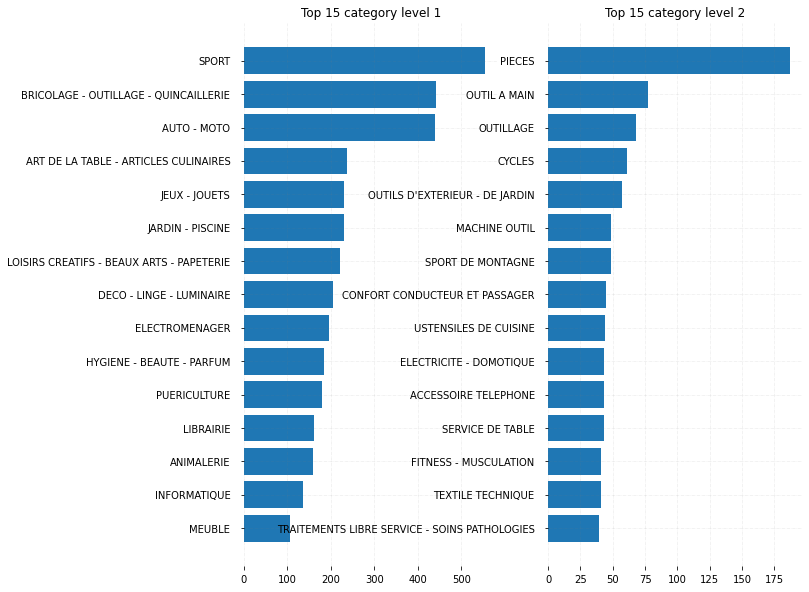

In [12]:
col_name=['category_level1', 'category_level2']
fig, ax = plt.subplots(1,2,figsize =(10, 10))
ax = ax.flatten()
ax[0].set_title('Top 15 category level 1')
ax[1].set_title('Top 15 category level 2')




for i, cat in enumerate(col_name):

    # print('index=', i, 'category=', cat)
    cat1_count = categories_df[cat].value_counts().to_frame().reset_index()
    name_cat1 = cat1_count['index'].head(15)
    count_cat1 = cat1_count[cat].head(15)

    # Figure Size
    # fig, ax = plt.subplots(2,2,figsize =(16, 16))
    # because ax will be a 2D array an we are converting into 1D array
    # Add padding between axes and labels
    ax[i].xaxis.set_tick_params(pad=5)
    ax[i].yaxis.set_tick_params(pad=10)

    # Horizontal Bar Plot
    ax[i].barh(name_cat1, count_cat1)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[s].set_visible(False)

    # Add x, y gridlines
    ax[i].grid(b=True, color='grey', linestyle='-.',
                 linewidth=0.5, alpha=0.2)

    # Show top values
    ax[i].invert_yaxis()

    # # # Add Text watermark
    # # fig.text(0.9, 0.15, 'Sarthak Kaushik', fontsize = 12,
    # #          color ='grey', ha ='right', va ='bottom',
    # #          alpha = 0.7)

    # #Add annotation to bars
    # for i in ax[i].patches:
    #     plt.text(i.get_width()+0.2, i.get_y()+0.5,
    #              str(round((i.get_width()), 2)),
    #              fontsize = 10, fontweight ='bold',
    #              color ='grey')

    # Add Plot Title
    # print("type-",type(cat),cat)
    # ax[i].set_title('Top 5 ',cat, loc='center', )

    
 

#Exploring Train_example BSON File

In [14]:
# read bson file into pandas DataFrame
data_dir = "../cdiscount/"
train_example_bson_path = os.path.join(data_dir, "train_example.bson")
with open(train_example_bson_path,'rb') as b:
    df_example = pd.DataFrame(bson.decode_all(b.read()))
    
# convert binary image to raw image and store in the imgs column
df_example['imgs'] = df_example['imgs'].apply(lambda rec: rec[0]['picture'])
df_example['imgs'] = df_example['imgs'].apply(lambda img: Image.open(io.BytesIO(img)))

In [15]:
df_example.head()

,_id,imgs,category_id
0,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1000010653
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1000010653
2,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1000004079
3,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1000004141
4,4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1000015539


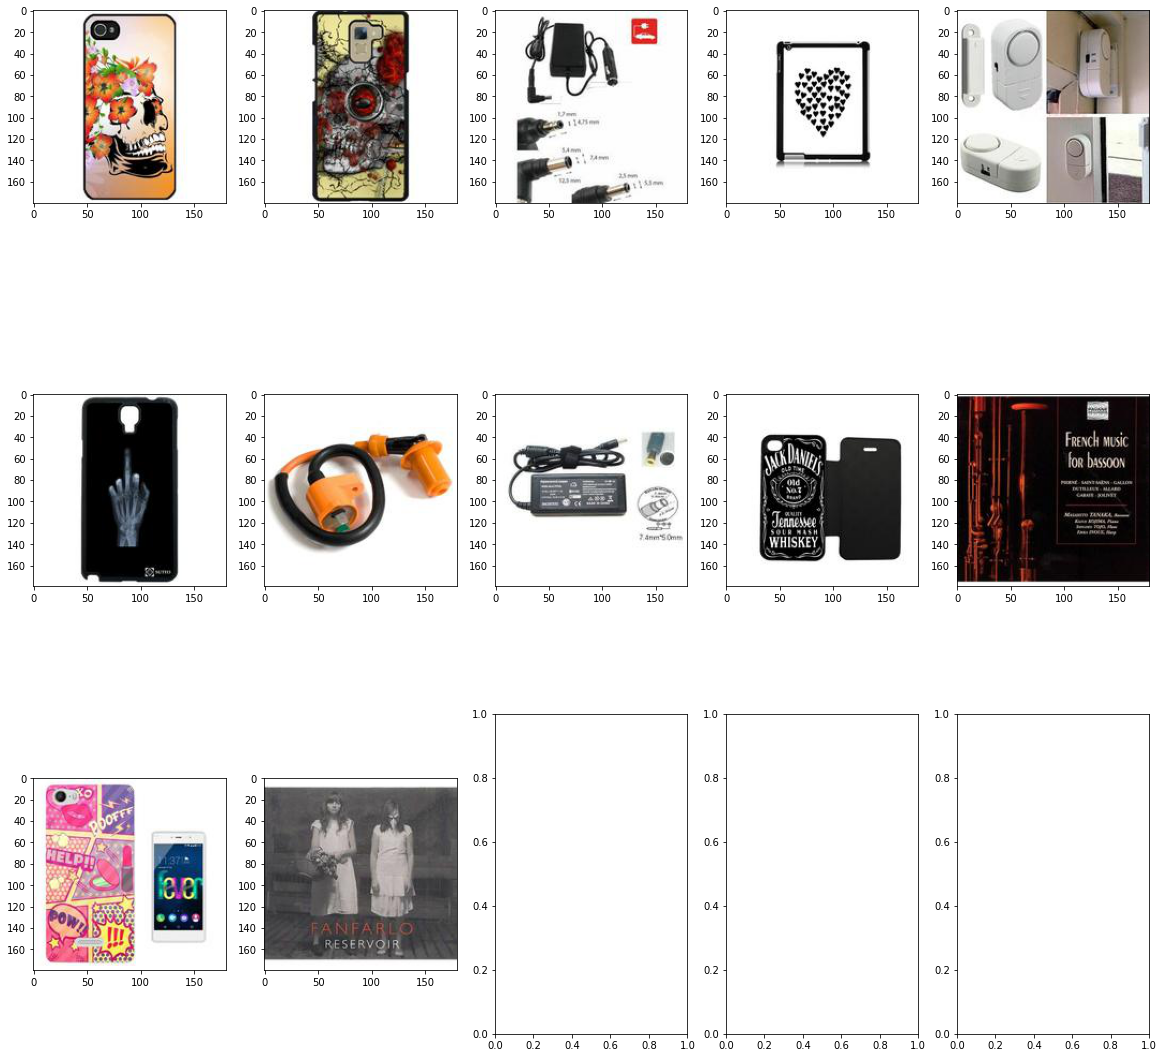

In [16]:
rows, cols = 3, 5

with open(train_example_bson_path, 'rb') as f:
    data = bson.decode_file_iter(f)

    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
    ax = ax.flatten()

    i = 0
    for c, d in enumerate(data):
      if i<12:
        product_id = d['_id']
        category_id = d['category_id']
        for e, pic in enumerate(d['imgs']):
          picture = imread(io.BytesIO(pic['picture']))
          ax[i].imshow(picture)
          i = i + 1
      else:
        break

            
   

    # except IndexError:
    #     plt.tight_layout()

#Exploring Train.bson File

In [17]:
data_dir = "../cdiscount/"
train_bson_path = os.path.join(data_dir, "train.bson")


In [18]:
prod_id = []
prod_category = []
prod_num_imgs = []
prod_imgs=[]

num_dicts = 7069896 # according to data page

# This will take about 02m15s to complete
with open(train_bson_path, 'rb') as f, tqdm_notebook(total=num_dicts) as bar:
        
    data = bson.decode_file_iter(f)
    
    for c, d in enumerate(data):
        bar.update()
        prod_id.append(d['_id'])
        prod_category.append(d['category_id'])
        prod_num_imgs.append(len(d['imgs']))
        # print(d['imgs'])
        # img_ls=[]
        # for e, pic in enumerate(d['imgs']):
        #   print(pic)
          # img_ls.append(pic['picture'].apply(lambda rec: rec[0]['picture']))
        # prod_imgs.append(img_ls)
               
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/7069896 [00:00<?, ?it/s]

In [19]:
#Create the dataframe
df_dict = {
    'category_id': prod_category,
    '_id': prod_id,
    'num_imgs': prod_num_imgs
}# we are not loading images as it will take lot of memory 
df = pd.DataFrame(df_dict)
del df_dict # Free memory

In [20]:
df.head()

,category_id,_id,num_imgs
0,1000010653,0,1
1,1000010653,1,1
2,1000004079,2,1
3,1000004141,3,1
4,1000015539,4,1


In [21]:
# Now merging  df with category table to creat 'train' table

train = df.merge(categories_df,on='category_id')
train.head()


,category_id,_id,num_imgs,category_level1,category_level2,category_level3
0,1000010653,0,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
1,1000010653,1,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
2,1000010653,5,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
3,1000010653,11,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE
4,1000010653,16,1,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE


In [22]:
train.shape

(7069896, 6)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7069896 entries, 0 to 7069895
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   category_id      int64 
 1   _id              int64 
 2   num_imgs         int64 
 3   category_level1  object
 4   category_level2  object
 5   category_level3  object
dtypes: int64(3), object(3)
memory usage: 377.6+ MB


In [24]:
#No of Unique products_id and Category_id
print("Unique product_id: ", len(train['_id'].unique()))
print("Unique categories: ", len(train['category_id'].unique()))

# So we have same unique category id in both train and Category file.

Unique product_id:  7069896
Unique categories:  5270


In [25]:
# Number of Image Per Category Product

train['num_imgs'].value_counts()

1    4369441
2    1128588
4    1029075
3     542792
Name: num_imgs, dtype: int64

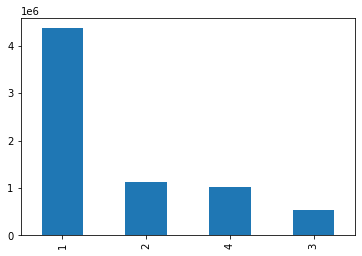

In [26]:
train.num_imgs.value_counts().plot(kind='bar');#Most of the product has only 1 images

Text(0, 0.5, 'Number of classes/Categories')

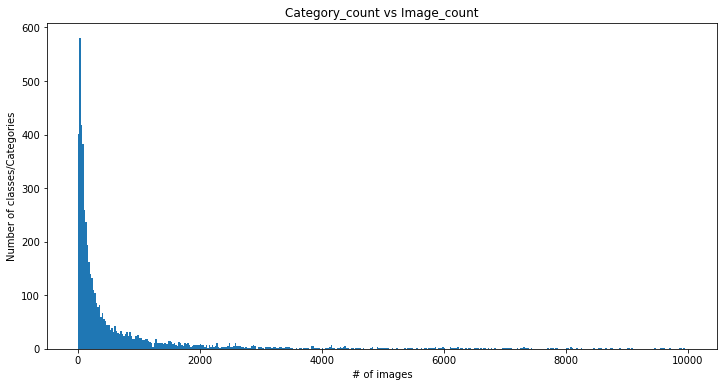

In [28]:
# Lets understand no. of categories w.r.t no. of images
train_categories_gb = train.groupby('category_id')
train_categories_count = train_categories_gb['category_id'].count()
plt.figure(figsize=(12, 6))
plt.title('Category_count vs Image_count')
bin_size = 25
plt.hist(train_categories_count, bins=range(0, int(1e4), bin_size))
plt.xlabel('# of images')
plt.ylabel('Number of classes/Categories')

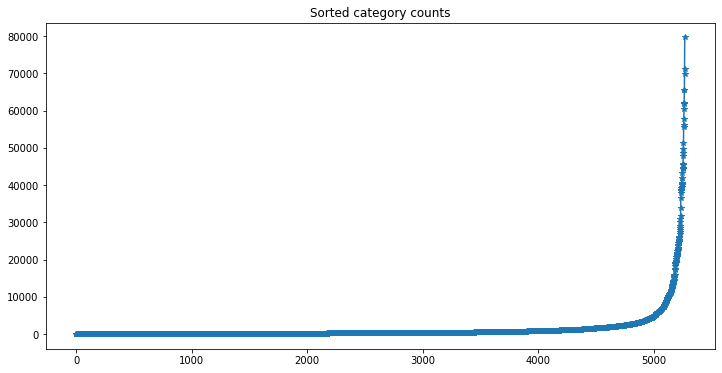

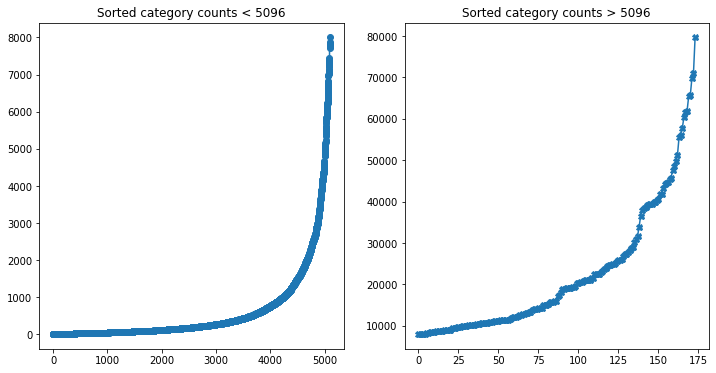

In [29]:
# Here is a plot of sorted category counts

sorted_train_categories_count = sorted(train_categories_count.values)
index_8000 = np.where(np.array(sorted_train_categories_count) > 8000)[0][0]

plt.figure(figsize=(12, 6))
plt.title("Sorted category counts")
_ = plt.plot(sorted_train_categories_count, '*-')

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Sorted category counts < %i" % index_8000)
_ = plt.plot(sorted_train_categories_count[:index_8000], 'o-')

plt.subplot(122)
plt.title("Sorted category counts > %i" % index_8000)
_ = plt.plot(sorted_train_categories_count[index_8000:], 'X-')

In [30]:
# Let's see the top 15 most common category joining train and category file



In [31]:
temp=df['category_id'].value_counts().to_frame().head(15).reset_index()
temp.columns=['category_id','counts']
# temp.head()
# temp['category_id'].to_list()
categories_df[categories_df['category_id'].isin(temp['category_id'].to_list())]

,category_id,category_level1,category_level2,category_level3
515,1000005509,AUTO - MOTO,CONFORT CONDUCTEUR ET PASSAGER,PERSONNALISATION VEHICULE - DECORATION VEHICULE
2501,1000015912,INFORMATIQUE,COMPOSANT - PIECE DETACHEE,CLAVIER (PIECE DETACHEE)
2503,1000008094,INFORMATIQUE,COMPOSANT - PIECE DETACHEE,DALLE D'ECRAN
2522,1000004085,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,BATTERIE D'ALIMENTATION INFORMATIQUE
2530,1000004079,INFORMATIQUE,CONNECTIQUE - ALIMENTATION,CHARGEUR - ADAPTATEUR SECTEUR - ALLUME CIGARE ...
2548,1000011427,INFORMATIQUE,IMPRESSION - SCANNER,CARTOUCHE IMPRIMANTE
2560,1000011423,INFORMATIQUE,IMPRESSION - SCANNER,TONER - RECUPERATEUR DE TONER
3253,1000015309,LIBRAIRIE,AUTRES LIVRES,AUTRES LIVRES
3335,1000014202,LIBRAIRIE,LITTERATURE,LITTERATURE FRANCAISE
3956,1000018290,MUSIQUE,CD,CD MUSIQUE CLASSIQUE


In [39]:
# 'Let's see the least 15 least common category from the category table'

temp=df['category_id'].value_counts().to_frame().tail(15).reset_index()
temp.columns=['category_id','counts']
categories_df[categories_df['category_id'].isin(temp['category_id'].to_list())]

,category_id,category_level1,category_level2,category_level3
981,1000022465,BATEAU MOTEUR - VOILIER,ELECTRICITE,CONVERTISSEUR DE TENSION
1535,1000015609,CHAUSSURES - ACCESSOIRES,ACCESSOIRES CHAUSSURES,ESSUIE-BOTTES - LAVE-BOTTES
2241,1000000896,EPICERIE,CONSERVE DE LEGUME,POIVRON EN CONSERVE
3452,1000014467,LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE,COLLECTION - PHILATELIE - CARTOPHILIE - NUMISM...,TROUSSE D'EXPERTISE - PACK MULTI-OUTILS
3667,1000015046,MATERIEL DE BUREAU,MATERIEL PEDAGOGIQUE,REGISTRE D'APPEL - CAHIER DE CLASSE
3711,1000011519,MATERIEL MEDICAL,ACUPUNCTURE - MEDECINES PARALELLES,VENTOUSE
3785,1000011955,MATERIEL MEDICAL,SOIN,CATHETER - OBTURATEUR
3846,1000019484,MEUBLE,ACCESSOIRE DE MEUBLE,COLONNE SUSPENDUE
4154,1000019608,PHOTO - OPTIQUE,PIECES DETACHEES PHOTO - OPTIQUE,LECTEUR CARTE MEMOIRE - HUB
4179,1000010893,PHOTO - OPTIQUE,VISIONNAGE PHOTO,SCANNER DE DIAPOSITIVE


In [33]:
#Lets see the Category Level1 in train data

catlvl1 = train['category_level1'].value_counts()
# cats.head(15)
print ('No. of Category level1 :',len(catlvl1))
print(catlvl1.head())

No. of Category level1 : 49
AUTO - MOTO                 779158
INFORMATIQUE                711066
LIBRAIRIE                   613354
TELEPHONIE - GPS            591516
DECO - LINGE - LUMINAIRE    584467
Name: category_level1, dtype: int64


In [34]:
# Taking out the first word from the name
abbriv = catlvl1.index.str.split('\W').str[0]
abbriv

Index(['AUTO', 'INFORMATIQUE', 'LIBRAIRIE', 'TELEPHONIE', 'DECO', 'BRICOLAGE',
       'MUSIQUE', 'BIJOUX', 'JEUX', 'SPORT', 'HYGIENE', 'ELECTROMENAGER',
       'ART', 'TV', 'BAGAGERIE', 'PHOTO', 'MEUBLE', 'CHAUSSURES', 'LOISIRS',
       'JARDIN', 'ANIMALERIE', 'DVD', 'PUERICULTURE', 'JEUX', 'TATOUAGE',
       'ARTICLES', 'LITERIE', 'INSTRUMENTS', 'PARAPHARMACIE', 'DROGUERIE',
       'EPICERIE', 'MATERIEL', 'MERCERIE', 'ELECTRONIQUE', 'SONO', 'TENUE',
       'VIN', 'MATERIEL', 'BATEAU', 'CONDITIONNEMENT', 'POINT', 'MANUTENTION',
       'AMENAGEMENT', 'COFFRET', 'FUNERAIRE', 'PRODUITS', 'ABONNEMENT',
       'PRODUITS', 'APICULTURE'],
      dtype='object')

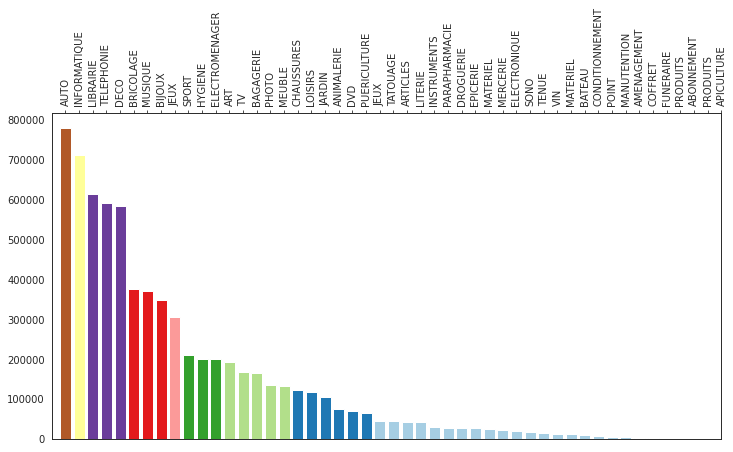

In [35]:
import seaborn as sns
import cv2 #opencv helpful for storing image as array

from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

sns.set_style('white')
fig,ax = plt.subplots(1,figsize=(12,6))
pal = ListedColormap(sns.color_palette('Paired').as_hex())
colors = pal(np.interp(catlvl1,[catlvl1.min(),catlvl1.max()],[0,1]))
bars = ax.bar(range(1,len(catlvl1)+1),catlvl1,color=colors);
ax.set_xticks([]);
ax.set_xlim(0,len(catlvl1))
ax1 = plt.twiny(ax)
ax1.set_xlim(0,len(catlvl1))
ax1.set_xticks(range(1,len(abbriv)+1,1));
ax1.set_xticklabels(abbriv.values,rotation=90);


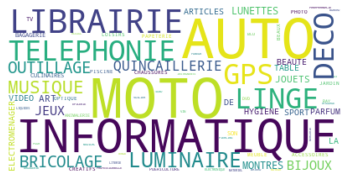

In [36]:
# Lets Create a word cloud for Category level 1
word_cloud = WordCloud(collocations = False, background_color = 'white')
word_cloud.generate(' '.join(train.iloc[:,3].values.flatten()))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


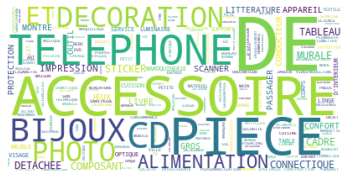

In [37]:
# Lets Create a word cloud for Category level 2
word_cloud = WordCloud(collocations = False, background_color = 'white')
word_cloud.generate(' '.join(train.iloc[:,4].values.flatten()))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


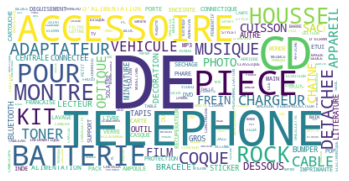

In [38]:
# Lets Create a word cloud for Category level 3
word_cloud = WordCloud(collocations = False, background_color = 'white')
word_cloud.generate(' '.join(train.iloc[:,5].values.flatten()))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Lets have look at test.bson file

In [40]:
data_dir = "../cdiscount/"

test_bson_path = os.path.join(data_dir, "test.bson")

In [41]:
prod_id = []
prod_category = []
prod_num_imgs = []
prod_imgs=[]


with open(test_bson_path, 'rb') as f:

  
        
    data = bson.decode_file_iter(f)
    
    
    
    for c, d in enumerate(data):
      if c <1000:

        # print(c)
        prod_id.append(d['_id'])
        prod_num_imgs.append(len(d['imgs']))
      else:
        break
           
      
      
#Create the dataframe
df_dict = {
    
    '_id': prod_id,
    'num_imgs': prod_num_imgs
}# we are not loading images as it will take lot of memory 
df_test = pd.DataFrame(df_dict)
del df_dict # Free memory

df_test.head()


### he goal of the competition is to predict category_id by image. We need to predict a number, e.g. 1000010653 by an image.


,_id,num_imgs
0,10,3
1,14,1
2,21,1
3,24,1
4,27,1
